In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import pandas as pd
import pickle as pkl
import seaborn as sns
import sklearn
from time import time 


from setup import *

In [4]:
version = '2023-07-01T02-22-28'
epoch = 69

# Load Model Embeddings

In [16]:
ckpt = '/dreambig/qingyi/stable-diffusion/logs/'+version+'_sae_kl_8x8x64/checkpoints/epoch='+f"{epoch:06d}"+'.ckpt'
config = OmegaConf.load('/dreambig/qingyi/stable-diffusion/logs/'+version+'_sae_kl_8x8x64/configs/'+version+'-project.yaml')

with open(proj_dir+"latent_space/"+version+"_sae_kl_f32_ep"+str(epoch)+".pkl", "rb") as f:
# with open(proj_dir+"latent_space/"+version+"_sae_"+
#       str(config['model']['params']['ddconfig']['output_dim'])+"_"+
#       str(config['model']['params']['lossconfig']['params']['supervision_factor'])+
#       "_ep"+str(epoch)+".pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)

In [3]:
# print(proj_dir+"latent_space/"+version+"_sae_"+
#       str(config['model']['params']['ddconfig']['output_dim'])+"_"+
#       str(config['model']['params']['lossconfig']['params']['supervision_factor'])+
#       "_ep"+str(epoch)+".pkl")

# Aggregate Embeddings

In [17]:
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
#     aggregate_embeddings.append(np.mean(sup_list[ct == i], axis=0))
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)


In [18]:
aggregate_embeddings = aggregate_embeddings.reshape(aggregate_embeddings.shape[0], -1)

# Latent Space Visualization with tSNE

In [5]:
# check if tSNE is already done
tsne_file = []# glob.glob(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+v1+"_"+model_run_date+".csv")


In [6]:
if len(tsne_file) != 0:
    df_ct = pd.read_csv(tsne_file[0])
else:
    from sklearn import manifold
    method = manifold.TSNE(n_components=2, init='pca', random_state=5)
    t0 = time()
    # tsne_im = method.fit_transform(encoder_output)
    tsne_ct = method.fit_transform(aggregate_embeddings)
    t1 = time()
    print("tSNE Running time %s: %d sec" % ('Time', t1 - t0))

    demo_df = pd.read_csv(data_dir+"Census_old/demo_tract.csv")
    demo_df['pop_density'] = demo_df['tot_population'] / demo_df['area']
    demo_df['COUNTYA'] = demo_df['COUNTYA'].astype('str')

    # tSNE done on individual images
    # df_im = pd.DataFrame(tsne_im, columns = ['x0', 'x1'])
    # df_im['geoid'] = ct
    # df_im = pd.merge(df_im, demo_df, on='geoid')

    # tSNE done on aggregate embeddings
    df_ct = pd.DataFrame(tsne_ct, columns = ['x0', 'x1'])
    df_ct['geoid'] = unique_ct

    df_ct = pd.merge(df_ct, demo_df, on='geoid')

    print(df_ct.columns.tolist())

    df_ct['pop_density'] /= 1000
    df_ct['inc_per_capita'] /= 1000
    df_ct['pct_adult'] = df_ct['pct25_34yrs']+df_ct['pct35_50yrs']
    df_ct['pct_senior'] = df_ct['pctover65yrs']

tSNE Running time Time: 14 sec
['x0', 'x1', 'geoid', 'COUNTYA', 'TRACTA', 'tot_population', 'pct25_34yrs', 'pct35_50yrs', 'pctover65yrs', 'pctwhite_alone', 'pct_nonwhite', 'pctblack_alone', 'pct_col_grad', 'pctPTcommute', '25_34yrs', '35_50yrs', 'over65yrs', 'white_alone', 'nonwhite', 'black_alone', 'col_grad', 'PTcommute', 'avg_tt_to_work', 'inc_per_capita', 'area', 'INTPTLAT', 'INTPTLON', 'pop_density']


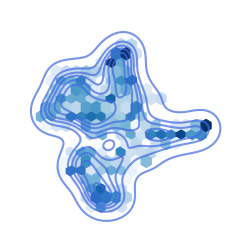

In [7]:
# density plot
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(data=df_ct, x='x0',y='x1',ax=ax, levels=7, color='royalblue', alpha=0.7)
ax.axis('off')
plt.show()
fig.savefig(out_dir+"density_"+str(epoch)+".png", bbox_inches='tight')

In [9]:
def plot_hex(var, cmap):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    im = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), C=df_ct[var], gridsize=17, cmap=cmap)
    cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    fig.colorbar(im, cax=cax)
    ax.axis('off')
    fig.savefig(out_dir+"Figures/"+var+"_"+str(epoch)+".png", bbox_inches='tight')
    return fig

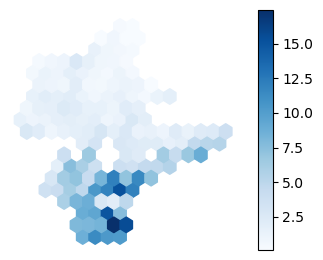

In [10]:
plot_hex('pop_density', 'Blues');
plt.show()

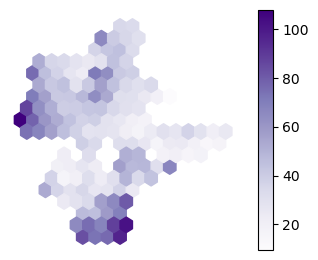

In [11]:
plot_hex('inc_per_capita', 'Purples');
plt.show()

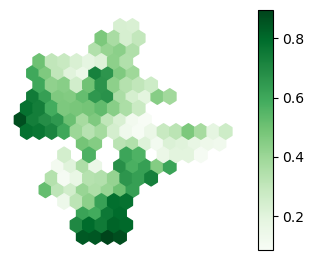

In [12]:
plot_hex('pct_col_grad', 'Greens');
plt.show()

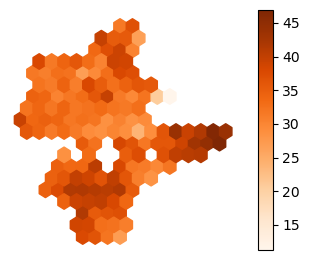

In [13]:
plot_hex('avg_tt_to_work', 'Oranges');
plt.show()

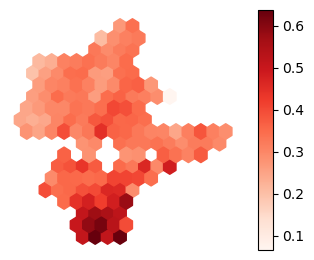

In [14]:
plot_hex('pct_adult', 'Reds');
plt.show()

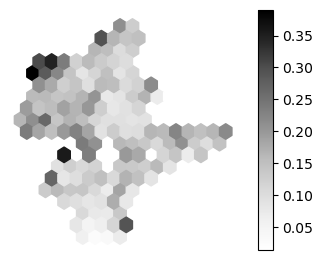

In [15]:
plot_hex('pct_senior', 'Greys');
plt.show()

# Latent Space Clustering

In [16]:
from sklearn.cluster import KMeans

kmeans_ct = KMeans(n_clusters=5)
kmeans_ct.fit(aggregate_embeddings)
df_ct['kmeans'] = kmeans_ct.labels_

pd.Series(kmeans_ct.labels_).value_counts().sort_index()

/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    702
1    337
2    154
3    100
4    295
dtype: int64

723 60.79035
228 94.79354
1003 84.14978
482 74.58435
38 60.069485


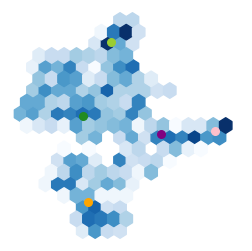

In [17]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), gridsize=17, mincnt=1, cmap='Blues')
# sns.kdeplot(x=df_ct["x0"].to_numpy(), y=df_ct["x1"].to_numpy(), ax=ax, levels=7, color='royalblue')

colors = ['forestgreen','orange','purple','pink','yellowgreen','black']
i = 0
for c in kmeans_ct.cluster_centers_:
    idx = np.argmin(sklearn.metrics.pairwise_distances(aggregate_embeddings, c.reshape(1,-1)))
    print(idx+2, np.min(sklearn.metrics.pairwise_distances(aggregate_embeddings, c.reshape(1,-1))))
    ax.scatter(df_ct.iloc[idx]["x0"], df_ct.iloc[idx]["x1"], c=colors[i],s=30)
    i += 1

plt.axis("off")
plt.show()

# fig.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
#                     model_run_date+"_traj.png", bbox_inches='tight')
    

In [54]:
import torchvision
import torch

from PIL import Image

In [85]:
s = int((600 - 256) // 2)
e = int((600 + 256) // 2)


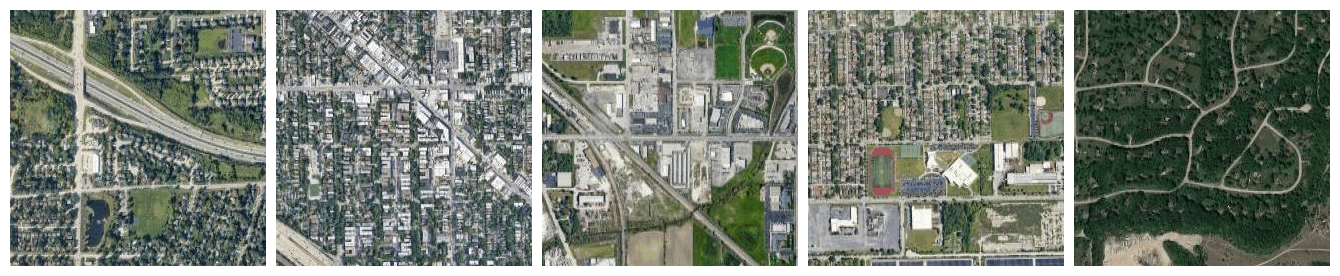

In [108]:
grid = []
for c in df_ct.iloc[[721, 226,1001,480,36]].sort_values(by='kmeans')['geoid'].to_list():
    image = Image.open(image_dir+"zoom15/"+c+"_5.png")
    image = image.convert("RGB")
    image = np.array(image).astype(np.uint8)
    image = image[s:e, s:e, :]
    grid.append(torch.tensor(image).permute(2,0,1))

grid = torchvision.utils.make_grid(grid, nrow=5, padding=10, pad_value=-1)
grid = grid.transpose(0, 1).transpose(1, 2).squeeze(-1)
grid = grid.numpy()


Image.fromarray(grid)

In [17]:
print(sklearn.metrics.pairwise_distances(kmeans_ct.cluster_centers_))

[[  0.      224.14975 894.7284  439.2642  428.7289 ]
 [224.14975   0.      889.5613  405.46814 272.1251 ]
 [894.7284  889.5613    0.      512.9004  926.3363 ]
 [439.2642  405.46814 512.9004    0.      489.16858]
 [428.7289  272.1251  926.3363  489.16858   0.     ]]


In [18]:
df_ct[['geoid','COUNTYA','TRACTA', 'x0','x1','kmeans']].to_csv(\
        out_dir+"kmeans_"+str(epoch)+".csv", index=False)


In [5]:
# change environment and read saved results
df_ct = pd.read_csv(out_dir+"kmeans_"+str(epoch)+".csv")

In [6]:
import geopandas as gpd
# import geoplot as gplt
# import geoplot.crs as gcrs
 

In [7]:
shp = gpd.read_file(data_dir+"Shapefiles/tl_2018_17_tract/tl_2018_17_tract.shp")

shp['geoid'] = shp['STATEFP'].astype(str)+'_'+shp['COUNTYFP'].str.lstrip('0')+'_'+shp['TRACTCE'].str.lstrip('0')
# shp['geometry'] = shp['geometry'].to_crs('epsg:26916')

f = pd.read_csv(data_dir+"TrainTestSplit/census_tracts_filtered-1571.csv")

shp_f = pd.merge(shp, f, on='geoid')

shp_ct = pd.merge(shp, df_ct, on='geoid')

In [12]:
shp_ct['kmeans'] += 1

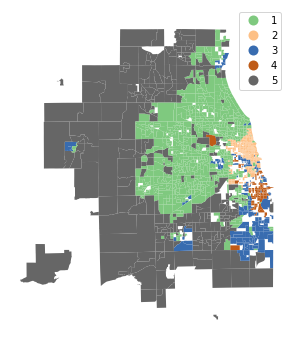

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
shp_ct.plot(column='kmeans', categorical=True, ax=ax, legend=True, cmap='Accent')
ax.set_ylim([41.1, 42.6])
ax.axis('off')
fig.savefig(out_dir+"Figures/kmeans_all_"+str(epoch)+".png", bbox_inches='tight')

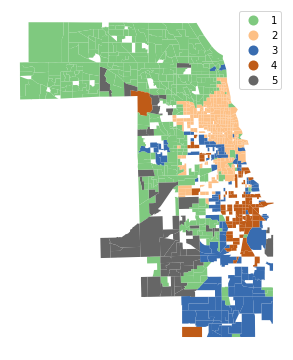

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
shp_ct[shp_ct['COUNTYFP']=='031'].plot(column='kmeans', categorical=True, ax=ax, legend=True, cmap='Accent')
ax.axis('off')
fig.savefig(out_dir+"Figures/kmeans_cook_"+str(epoch)+".png", bbox_inches='tight')

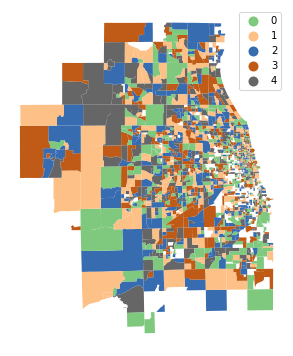

In [37]:
# Train test split

fig, ax = plt.subplots(1,1,figsize=(5,10))
shp_f.plot(column='train_test', categorical=True, ax=ax, legend=True, cmap='Accent')
ax.axis('off')
fig.savefig("traintestsplit_"+str(epoch)+".png", bbox_inches='tight')

# Create perturbed epsilon around existing embeddings
- good quality images can only be obtained from high latent space dimension

In [56]:
n = 20

sample_embedding = encoder_output[:n, :]
embedding_dim = sample_embedding.shape[1]

from torchvision import transforms
for i in range(n): 
    fig, ax = plt.subplots(1,4, figsize=(20,6))
    decoder_in = torch.tensor(sample_embedding[i])
    decoder_in = decoder_in.to(device)
    decoder_in = decoder_in.view(1, -1, output_dim, output_dim)
    reconstruct = decoder(decoder_in)[0]
    reconstruct = inverse_transform(reconstruct.cpu())

    im = transforms.ToPILImage()(reconstruct).convert("RGB")
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title("Original")
    
    for e in range(3,0,-1):
        decoder_in = torch.tensor(sample_embedding[i])
        epsilon = torch.normal(0, 10**(-e), size = (output_dim,)).view(-1)
        decoder_in += epsilon

        decoder_in = decoder_in.view(1, -1, output_dim, output_dim)
        decoder_in = decoder_in.to(device)
        reconstruct = decoder(decoder_in)[0]
        reconstruct = inverse_transform(reconstruct.cpu())

        im = transforms.ToPILImage()(reconstruct).convert("RGB")
        ax[4-e].imshow(im)
        ax[4-e].axis('off')
        ax[4-e].set_title(str(10**(3-e))+"%")
    
    fig.savefig(out_dir+"image_samples/latent_perturb/"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+ct[i]+".png")
